In [21]:
import sys, os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
# Load & clean
df = (
    pd.read_csv(
        '../data/historical_consumption.csv',
        skipinitialspace=True,
        parse_dates=['Datum'],
        dayfirst=True
    )
    .rename(columns={'potrosnja':'Potrošnja'})
    .sort_values('Datum')
    .set_index('Datum')
)
df['Potrošnja'] = df['Potrošnja'].fillna(0)

print("Versions:", scipy.__version__, sm.__version__)
display(df.head(), df.info())

Versions: 1.9.3 0.14.4
<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, 2023-01-01 to 2023-01-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Potrošnja  31 non-null     int64
dtypes: int64(1)
memory usage: 496.0+ bytes


,Potrošnja
Datum,
2023-01-01,150
2023-01-02,200
2023-01-03,10
2023-01-04,300
2023-01-05,600


None

In [23]:
# Train/valid split
split = int(len(df) * 0.8)
train, valid = df.iloc[:split], df.iloc[split:]
print(f"Train: {len(train)} rows, Valid: {len(valid)} rows")

Train: 24 rows, Valid: 7 rows


In [24]:
# Prophet proof-of-concept
prophet_train = train.reset_index().rename(columns={'Datum':'ds','Potrošnja':'y'})[['ds','y']]
prophet_valid = valid.reset_index().rename(columns={'Datum':'ds','Potrošnja':'y'})[['ds','y']]

m = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=False)
m.fit(prophet_train)

future = m.make_future_dataframe(periods=len(valid), freq='D')
forecast = m.predict(future)

pred_prophet = forecast.set_index('ds')['yhat'].iloc[-len(valid):].values
rmse_prophet = np.sqrt(mean_squared_error(prophet_valid['y'], pred_prophet))

print(f"Prophet RMSE: {rmse_prophet:.2f}")

21:50:51 - cmdstanpy - INFO - Chain [1] start processing
21:50:51 - cmdstanpy - INFO - Chain [1] done processing


Prophet RMSE: 691.94


In [25]:
# ARIMA proof-of-concept
order = (1,1,1)
arima_model = sm.tsa.ARIMA(train['Potrošnja'], order=order).fit()
pred_arima = arima_model.forecast(steps=len(valid))
rmse_arima = np.sqrt(mean_squared_error(valid['Potrošnja'], pred_arima))

print(arima_model.summary())
print(f"ARIMA{order} RMSE: {rmse_arima:.2f}")

C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Potrošnja   No. Observations:                   24
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -171.489
Date:                Thu, 10 Jul 2025   AIC                            348.978
Time:                        21:50:51   BIC                            352.384
Sample:                    01-01-2023   HQIC                           349.834
                         - 01-24-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6161      0.312      1.972      0.049       0.004       1.228
ma.L1         -0.9988     10.039     -0.099      0.921     -20.675      18.677
sigma2       1.62e+05   1.62e+06      0.100      0.9

C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
results = pd.DataFrame({
    'model': ['Prophet', f'ARIMA{order}'],
    'rmse':  [rmse_prophet, rmse_arima]
})
display(results)

,model,rmse
0,Prophet,691.941349
1,"ARIMA(1, 1, 1)",281.638909


In [27]:
from src.model import train_and_forecast_arima

res = train_and_forecast_arima(train, order=order, periods=len(valid))
mse = mean_squared_error(valid['Potrošnja'], res['forecast'])
print("AIC:", res['aic'], "| RMSE:", np.sqrt(mse))
display(res['forecast'].head())

C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC: 348.9776750082995 | RMSE: 281.6389085947712


2023-01-25    240.935667
2023-01-26    304.967148
2023-01-27    344.414921
2023-01-28    368.717448
2023-01-29    383.689467
Freq: D, Name: predicted_mean, dtype: float64

In [28]:
order    = (1,1,1)
H        = 7
min_train = 20

rmse_list = []
mae_list  = []

for i in range(min_train, len(df) - H):
    train_slice = df.iloc[:i]
    true_slice  = df['Potrošnja'].iloc[i : i+H]
    
    # forecast H steps
    res   = train_and_forecast_arima(train_slice, order=order, periods=H)
    pred  = res['forecast']
    
    # align and compute errors
    pred = pred.reindex(true_slice.index)  # sigurnost da su indeksi isti
    
    rmse_list.append(
        np.sqrt(np.mean((true_slice - pred) ** 2))
    )
    mae_list.append(
        mean_absolute_error(true_slice, pred)
    )

rolling_rmse = np.mean(rmse_list)  # prosječni RMSE preko svih windows
rolling_mae  = np.mean(mae_list)

print(f"Rolling {H}-day RMSE: {rolling_rmse:.2f}")
print(f"Rolling {H}-day MAE : {rolling_mae:.2f}")

C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-p

Rolling 7-day RMSE: 333.21
Rolling 7-day MAE : 313.63


C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\j\Desktop\projects\consumption-forecast\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


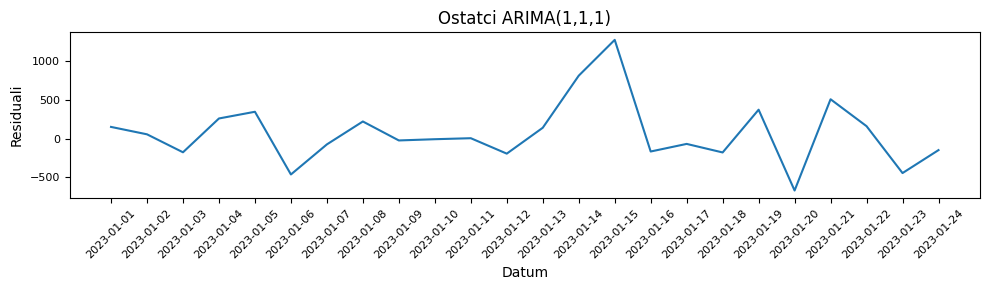

In [29]:
import matplotlib.pyplot as plt

residuals = arima_model.resid

plt.figure(figsize=(10,3))
plt.plot(residuals)
plt.title("Ostatci ARIMA(1,1,1)")
plt.xlabel("Datum")
plt.ylabel("Residuali")

# reduce tick label size
plt.tick_params(axis='x', labelsize=8, rotation=45)
plt.tick_params(axis='y', labelsize=8)

plt.tight_layout()  
plt.show()


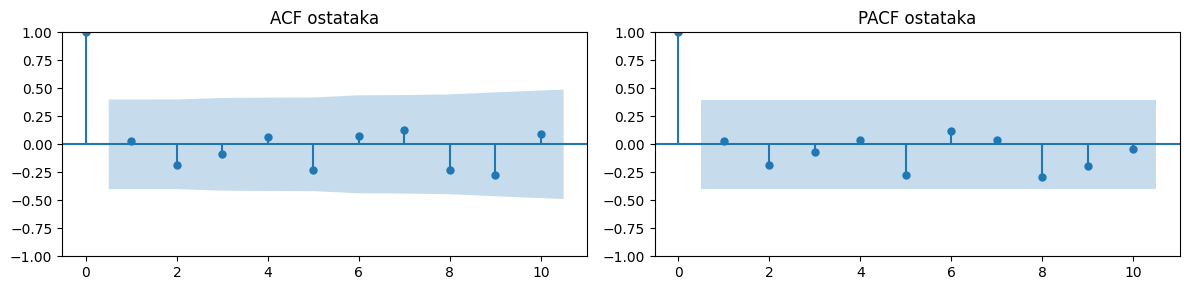

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1,2, figsize=(12,3))
plot_acf(residuals, lags=10, ax=axes[0], title="ACF ostataka")
plot_pacf(residuals, lags=10, ax=axes[1], title="PACF ostataka")
plt.tight_layout()
plt.show()


In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box test (lag=10):")
display(lb_test)


Ljung-Box test (lag=10):


,lb_stat,lb_pvalue
10,9.28982,0.504837


In [32]:
from statsmodels.stats.stattools import jarque_bera

jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
print(f"Jarque–Bera stat: {jb_stat:.2f}, p-value: {jb_pvalue:.3f}")

Jarque–Bera stat: 6.47, p-value: 0.039
